In [77]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from scipy.stats import bernoulli

In [60]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 256

lr = 0.001

In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        activation_1 = F.relu(self.fc1(x))
        x = self.fc2(activation_1)
        return x, torch.sign(activation_1)
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc1): Linear (3072 -> 256)
  (fc2): Linear (256 -> 10)
)


In [62]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        bins = range(0, hidden_layer_size)
        indexes1 = np.random.choice(self.train_activations.shape[0], 50000)
        indexes2 = np.random.choice(self.train_activations.shape[0], 50000)
        
        distances = np.abs(self.train_activations[indexes1] - self.train_activations[indexes2]).sum(1)
        plt.hist(distances, bins, label='Train Activations')
        print('Mean : %.2f, Std : %.2f' % (distances.mean(), distances.std()))
        
#         indexes1 = np.random.choice(self.test_activations.shape[0], 10000)
#         indexes2 = np.random.choice(self.test_activations.shape[0], 10000)
        
#         distances = np.abs(self.test_activations[indexes1] - self.train_activations[indexes2]).sum(1)
#         plt.hist(distances, bins, label='Test Activations')
        
        plt.legend()
        plt.title('Histogram of distances of activation patterns')
        plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [63]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [64]:
if cuda:
    model.cuda()
    criterion.cuda()

In [65]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
    for batch_idx, (data, target) in enumerate(testloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.test_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
        
    metrics.print_metrics()
    return metrics

Mean : 124.79, Std : 26.06


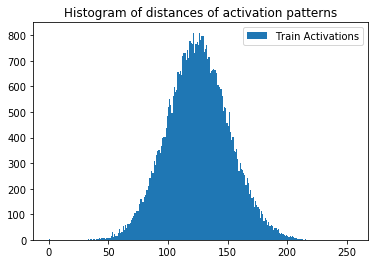

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.260756
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.647895
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.627287
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.836456
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.711298
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.752426
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.869991
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.570902

Test set: Average loss: 1.5576, Accuracy: 4560/10000 (46%)

Mean : 123.53, Std : 31.83


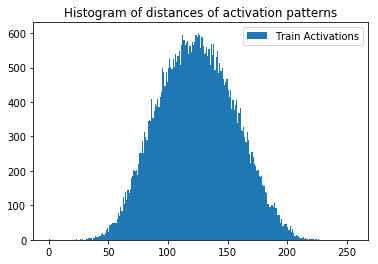

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.301647
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.332559
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.434767
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.146694
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.291351
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.671201
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.212998
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.466861

Test set: Average loss: 1.4559, Accuracy: 4876/10000 (49%)

Mean : 123.57, Std : 27.60


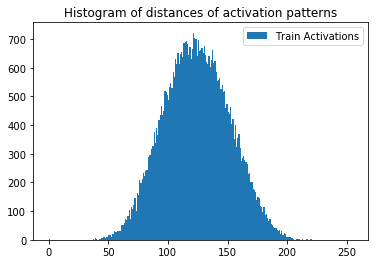

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.801796
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.355460
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.660351
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.082408
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.512317
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.288766
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.243043
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.171210

Test set: Average loss: 1.4246, Accuracy: 4962/10000 (50%)

Mean : 123.74, Std : 25.41


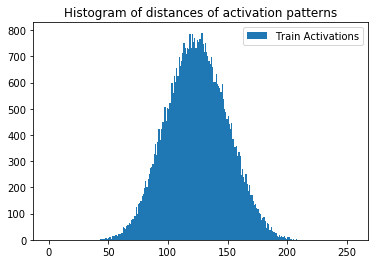

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.064737
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.420897
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.742912
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.112489
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.099424
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.754697
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.256608
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.096433

Test set: Average loss: 1.3768, Accuracy: 5136/10000 (51%)

Mean : 123.65, Std : 23.77


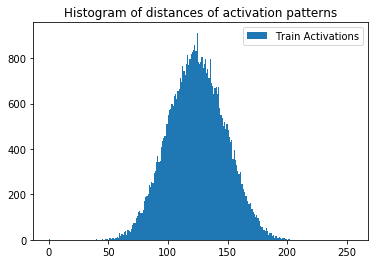

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.549989
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.252946
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.480118
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.326009
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.317077
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.982682
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.256154
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.081654

Test set: Average loss: 1.3728, Accuracy: 5145/10000 (51%)

Mean : 123.71, Std : 22.58


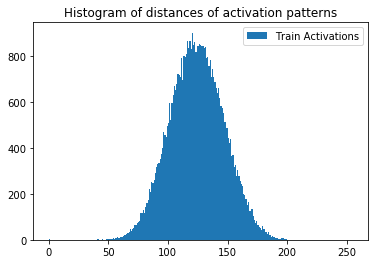

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.326513
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.405942
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.972539
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.508117
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.301863
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.920616
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.047477
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.823584

Test set: Average loss: 1.3930, Accuracy: 5062/10000 (51%)

Mean : 123.99, Std : 21.78


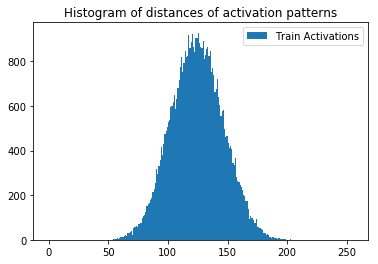

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.095191
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.698582
Train Epoch: 7 [12800/50000 (26%)]	Loss: 0.907540
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.116861
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.198021
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.204147
Train Epoch: 7 [38400/50000 (77%)]	Loss: 2.171809
Train Epoch: 7 [44800/50000 (90%)]	Loss: 1.213981

Test set: Average loss: 1.3564, Accuracy: 5260/10000 (53%)

Mean : 124.10, Std : 21.97


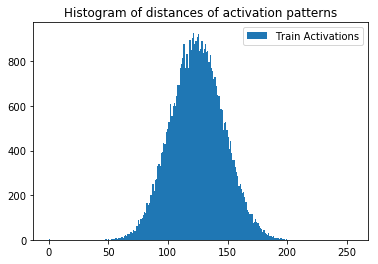

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.320542
Train Epoch: 8 [6400/50000 (13%)]	Loss: 1.061853
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.918026
Train Epoch: 8 [19200/50000 (38%)]	Loss: 1.059990
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.557184
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.977491
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.800870
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.427142

Test set: Average loss: 1.3592, Accuracy: 5224/10000 (52%)

Mean : 123.87, Std : 20.92


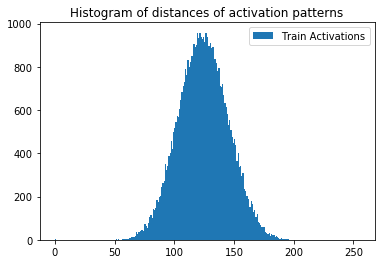

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.951532
Train Epoch: 9 [6400/50000 (13%)]	Loss: 1.079827
Train Epoch: 9 [12800/50000 (26%)]	Loss: 1.183856
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.357252
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.746677
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.982740
Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.884757
Train Epoch: 9 [44800/50000 (90%)]	Loss: 0.657473

Test set: Average loss: 1.3628, Accuracy: 5302/10000 (53%)

Mean : 123.84, Std : 20.73


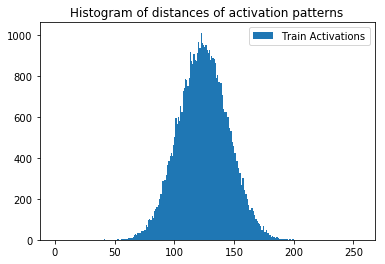

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.080825
Train Epoch: 10 [6400/50000 (13%)]	Loss: 1.389410
Train Epoch: 10 [12800/50000 (26%)]	Loss: 1.132083
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.993185
Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.642644
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.601334
Train Epoch: 10 [38400/50000 (77%)]	Loss: 1.002916
Train Epoch: 10 [44800/50000 (90%)]	Loss: 1.063090

Test set: Average loss: 1.3790, Accuracy: 5282/10000 (53%)



Process Process-289:
KeyboardInterrupt
Process Process-290:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap


KeyboardInterrupt: 

    self.run()
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
    racquire()
KeyboardInterrupt
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()


In [66]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()

# Activations pattern distances if random

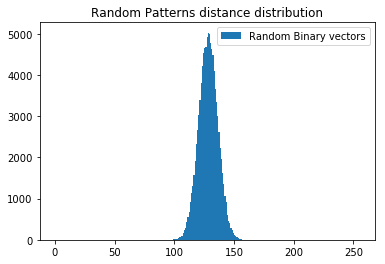

Mean : 127.95, Std : 8.00


In [51]:
elems = 100000
patterns1 = np.random.randint(2, size=(elems, hidden_layer_size))
patterns2 = np.random.randint(2, size=(elems, hidden_layer_size))

distance = np.abs(patterns1 - patterns2).sum(1)

bins = range(0, hidden_layer_size)
plt.hist(distance, label='Random Binary vectors', bins=bins)
plt.title('Random Patterns distance distribution')
plt.legend()
plt.show()
print('Mean : %.2f, Std : %.2f' % (distance.mean(), distance.std()))

# Activation pattern distance if mixtures - constelations

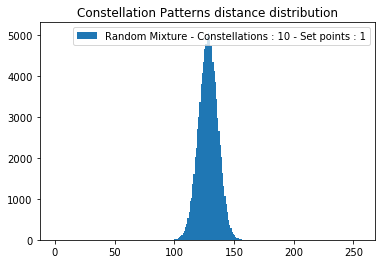

Mean : 127.97, Std : 8.00


In [89]:
nb_constellation = 10
set_points = 1

constellations = np.random.randint(2, size=(nb_constellation, set_points))

patterns1 = np.append(constellations[np.random.randint(nb_constellation, size=elems)], np.random.randint(2, size=(elems, hidden_layer_size - set_points)), axis=1)
patterns2 = np.append(constellations[np.random.randint(nb_constellation, size=elems)], np.random.randint(2, size=(elems, hidden_layer_size - set_points)), axis=1)

distance = np.abs(patterns1 - patterns2).sum(1)

bins = range(0, hidden_layer_size)
plt.hist(distance, label='Random Mixture - Constellations : %d - Set points : %d' % (nb_constellation, set_points), bins=bins)
plt.title('Constellation Patterns distance distribution')
plt.legend()
plt.show()
print('Mean : %.2f, Std : %.2f' % (distance.mean(), distance.std()))

# Activations pattern distances if random - bernouilli with normal parameter

((100000, 256), (100000, 256))


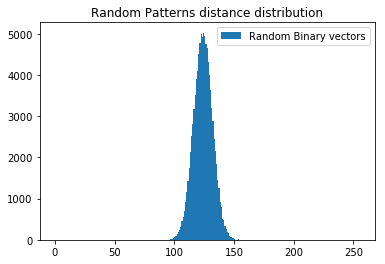

Mean : 123.58, Std : 7.94


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [83]:
elems = 100000

proba_activate = np.random.randn(hidden_layer_size) * .1 + .5

patterns1 = 0
patterns2 = 0

for i in range(hidden_layer_size):
    if type(patterns1) is np.ndarray:
        patterns1 = np.append(patterns1, bernoulli.rvs(proba_activate[i], size=(elems, 1)), axis=1)
        patterns2 = np.append(patterns2, bernoulli.rvs(proba_activate[i], size=(elems, 1)), axis=1)
    else:
        patterns1 = bernoulli.rvs(proba_activate[i], size=(elems, 1))
        patterns2 = bernoulli.rvs(proba_activate[i], size=(elems, 1))
print(patterns1.shape, patterns2.shape)

distance = np.abs(patterns1 - patterns2).sum(1)

bins = range(0, hidden_layer_size)
plt.hist(distance, label='Random Binary vectors', bins=bins)
plt.title('Random Patterns distance distribution')
plt.legend()
plt.show()
print('Mean : %.2f, Std : %.2f' % (distance.mean(), distance.std()))

bernoulli.rvs(.1, size=10)